<a href="https://colab.research.google.com/github/costpetrides/Temperature_Forecasting_MethodComparison/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-1075295365.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/content/Athens_meteo.csv", parse_dates=['DAY'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmbc3powh/hy5lafk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmbc3powh/w7zonuh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5997', 'data', 'file=/tmp/tmpmbc3powh/hy5lafk1.json', 'init=/tmp/tmpmbc3powh/w7zonuh7.json', 'output', 'file=/tmp/tmpmbc3powh/prophet_model0qmf4_1q/prophet_model-20250619121053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done proc

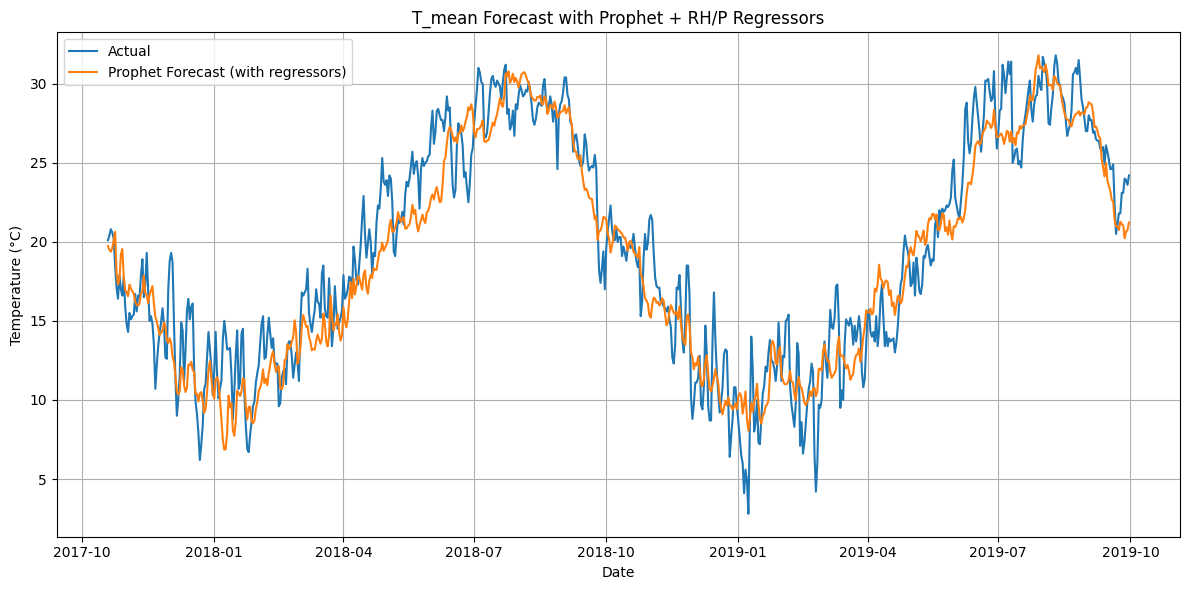

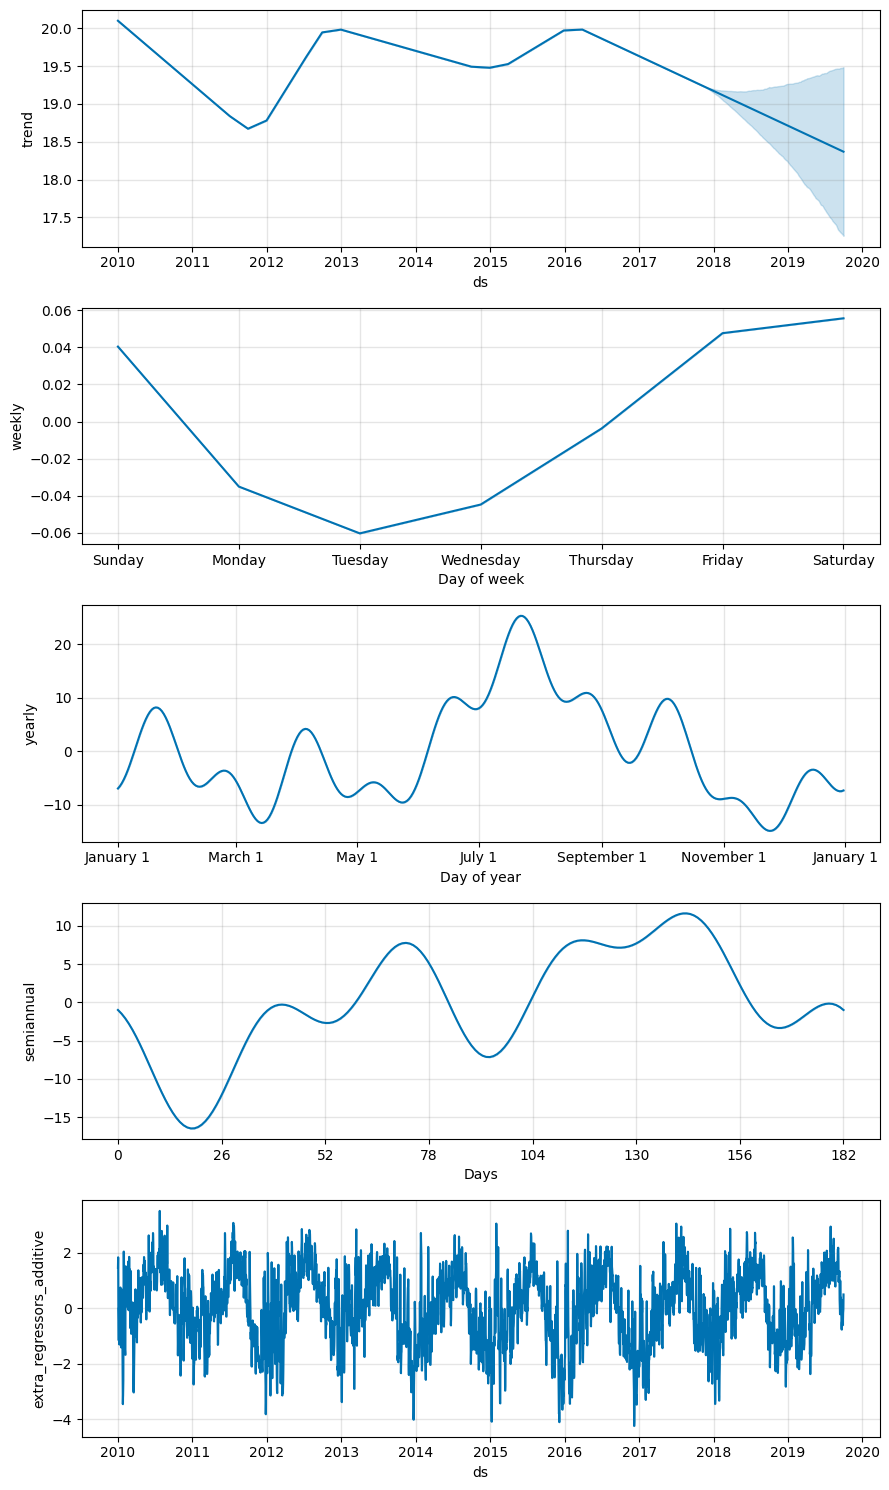


Prophet (with RH_mean & P_mean) Performance on Test Set
MAE : 1.90 °C
RMSE: 2.36 °C
R²  : 0.887


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────────────────────────────────────────────
# Load and clean data
df = pd.read_csv("/content/Athens_meteo.csv", parse_dates=['DAY'])
df = df[['DAY', 'T_mean', 'RH_mean', 'P_mean']]
df.dropna(inplace=True)

# Prophet expects columns: ds and y
df_prophet = df.rename(columns={'DAY': 'ds', 'T_mean': 'y'})

# ─────────────────────────────────────────────────────────────
# Chronological train/test split
split_index = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_index]
test_df = df_prophet.iloc[split_index:]

# ─────────────────────────────────────────────────────────────
# Initialize Prophet model with extra regressors and seasonality
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressors
model.add_regressor('RH_mean')
model.add_regressor('P_mean')

# Optional: add semiannual seasonality (e.g., warm/cold cycles)
model.add_seasonality(name='semiannual', period=182.5, fourier_order=5)

# Fit model
model.fit(train_df)

# ─────────────────────────────────────────────────────────────
# Forecasting
future = model.make_future_dataframe(periods=len(test_df))
# Merge regressors into the future DataFrame
future['RH_mean'] = df_prophet['RH_mean'].values
future['P_mean'] = df_prophet['P_mean'].values

# Predict
forecast = model.predict(future)

# ─────────────────────────────────────────────────────────────
# Evaluation on test set
forecast_test = forecast.iloc[-len(test_df):]
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# ─────────────────────────────────────────────────────────────
# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(test_df['ds'], y_pred, label='Prophet Forecast (with regressors)')
plt.title('T_mean Forecast with Prophet + RH/P Regressors')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prophet components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Print evaluation metrics
print("\nProphet (with RH_mean & P_mean) Performance on Test Set")
print(f"MAE : {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
print(f"R²  : {r2:.3f}")
